# Calculate Arctic Regional ice term averages from CESM2-LE

* **Description**: Reads in and creates regional averages from CESM2-LE
* **Input data**: CESM2-LE data, read using intake-esm
* **Output data**: Netcdf with processed ice state for all members
* **Creator**: Alice DuVivier
* **Date**: August 2022

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
import glob
import dask
from matplotlib.gridspec import GridSpec
import pandas as pd

import intake
from distributed import Client
from ncar_jobqueue import NCARCluster


Spin up dask cluster

In [2]:
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='32 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='P93300665', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41542 instead
  f"Port {expected} is already in use.\n"


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/41542/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/41542/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.32:45861,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/41542/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [4]:
# list the variables to load
var_in_1 = 'sispeed'
var_in_0 = 'aice'

In [5]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [6]:
#cat

### Load aice

In [7]:
forcing = 'cmip6'  # do not want smbb data
experiment = 'ssp370'

subset = cat.search(variable=var_in_0, forcing_variant=forcing, experiment=experiment )

In [8]:
#subset

In [9]:
# check that we only have cmip6, not smbb, data
member_id = list(subset.df.experiment.unique())
print(member_id)

['ssp370']


In [10]:
#subset.df.head()

Now we can use the [`to_dataset_dict`](https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict) method to return a dictionary of `xarray.Dataset`'s. `intake_esm` makes groups of these according to rules in the collection spec file.

We can use the `preprocess` parameter to pass in a function that makes some corrections to the dataset. So first we define a function that does the following:
- fix the time coordinate to be the middle of the interval
- subset to the time-interval 1950-2100

In [11]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets = subset.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})

#dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 6.48 s, sys: 358 ms, total: 6.84 s
Wall time: 19.9 s


In [12]:
# load in the datasets
future_ds_0 = []

for key in sorted(dsets.keys()):
    future_ds_0.append(dsets[key])
    print(key)

ice.ssp370.cice.h.cmip6.aice


In [13]:
futures_0 = xr.concat(future_ds_0, dim='member_id')

### Load variable

In [14]:
forcing = 'cmip6'  # do not want smbb data
experiment = 'ssp370'

subset = cat.search(variable=var_in_1, forcing_variant=forcing, experiment=experiment )

In [15]:
#subset

In [16]:
# check that we only have cmip6, not smbb, data
member_id = list(subset.df.experiment.unique())
print(member_id)

['ssp370']


In [17]:
#subset.df.head()

Now we can use the [`to_dataset_dict`](https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict) method to return a dictionary of `xarray.Dataset`'s. `intake_esm` makes groups of these according to rules in the collection spec file.

We can use the `preprocess` parameter to pass in a function that makes some corrections to the dataset. So first we define a function that does the following:
- fix the time coordinate to be the middle of the interval
- subset to the time-interval 1950-2100

In [18]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets = subset.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})

#dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 6.82 s, sys: 184 ms, total: 7.01 s
Wall time: 16.5 s


In [19]:
# load in the datasets
future_ds_1 = []

for key in sorted(dsets.keys()):
    future_ds_1.append(dsets[key])
    print(key)

ice.ssp370.cice.h.cmip6.sispeed


In [20]:
futures_1 = xr.concat(future_ds_1, dim='member_id')

### Continue processing both

In [21]:
futures_0['time'] = futures_0.time_bounds.load().mean(dim='d2').sel(member_id='r1i1281p1f1')
futures_1['time'] = futures_1.time_bounds.load().mean(dim='d2').sel(member_id='r1i1281p1f1')

In [22]:
futures_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [23]:
# set some info for output
longname = futures_1[var_in_1].long_name
units = futures_1[var_in_1].units

In [24]:
data_aice = futures_0[var_in_0]
data_all = futures_1[var_in_1]

## Get needed info for weighted averages

In [25]:
# get pop grid
grid = pop_tools.get_grid('POP_gx1v7')
grid

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60, nreg: 13)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/15)
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    ...           ...
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    region_name  (nreg) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

In [26]:
# convert tarea to m^2
tarea = grid['TAREA']/(1e4)
tarea=tarea.rename({'nlat':'nj','nlon': 'ni'})

In [27]:
# now we want to multiply data by tarea for area weighted average
data_all_mod = data_all*tarea

In [28]:
# also mask by where there is a very small ice fraction

# convert aice array to % not, fraction
data_aice = data_aice*100.0

# set ice concentration threshold to mask by
aicemin = 15.0

# mask dataset by the respective aice values
data_all_mod = data_all_mod.where(data_aice > aicemin)

## Apply regional mask to get area averages

In [29]:
# Load in masks
mask_in = ['nh_mask', 'Lab_mask', 'GIN_mask', 'Bar_mask', 'ArcOc_mask', 'Sib_mask', 'Beau_mask', 'Bering_mask', 'Hudson_mask', 'CAArch_mask', 'Okhotsk_mask']

ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/masks/REGION_MASK_gx1v7.nc')
ds_masks=ds_masks.rename({'lat':'nj','lon': 'ni'})
my_mask = ds_masks[mask_in].isel(time=0)

# now load in the different masks as a new coordinate
masks=xr.concat([my_mask.nh_mask,my_mask.Lab_mask,my_mask.GIN_mask,my_mask.Bar_mask,my_mask.ArcOc_mask,my_mask.Sib_mask,my_mask.Beau_mask,my_mask.Bering_mask,my_mask.Hudson_mask,my_mask.CAArch_mask,my_mask.Okhotsk_mask],dim='region')
masks['region']=mask_in

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Lab_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'GIN_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Bar_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'ArcOc_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decod

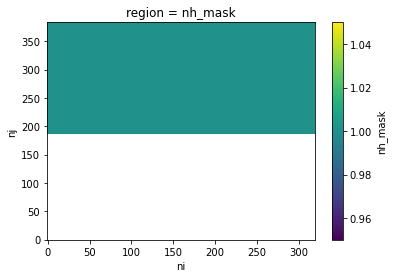

In [30]:
# verify it worked - choose one region to plot
masks.sel(region='nh_mask').plot()

In [31]:
masks

<xarray.DataArray 'nh_mask' (region: 11, nj: 384, ni: 320)>
dask.array<concatenate, shape=(11, 384, 320), dtype=float32, chunksize=(1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * region   (region) <U12 'nh_mask' 'Lab_mask' ... 'CAArch_mask' 'Okhotsk_mask'
Dimensions without coordinates: nj, ni

In [32]:
#mask just regions to calculate total ice area and ice volumes
data_all_masked = data_all_mod*masks
tarea_masked = tarea*masks

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/dask/array/core.py:4409: PerformanceWarning: Increasing number of chunks by factor of 11
  **blockwise_kwargs,


In [33]:
data_all_masked

,Array,Chunk
Bytes,519.65 GiB,112.50 MiB
Shape,"(50, 1032, 384, 320, 11)","(1, 120, 384, 320, 1)"
Count,12228 Tasks,4950 Chunks
Type,float64,numpy.ndarray


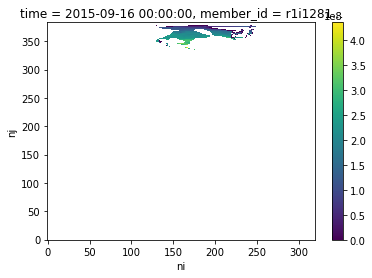

In [34]:
#just test that it worked properly
data_all_masked.sel(member_id='r1i1281p1f1',region='nh_mask').isel(time=8).plot()

## Calculate regional averages

- Sum both data_all_masked and tarea_masked over nj and ni.
- Divide SUM(data_all_masked) by SUM(tarea_masked)

In [35]:
# now sum by nj and ni and divide by the tarea summed by nj and ni (area weighted average)
total = data_all_masked.sum(dim=['nj','ni'])/tarea_masked.sum(dim=['nj','ni'])

In [36]:
total

,Array,Chunk
Bytes,4.33 MiB,0.94 kiB
Shape,"(50, 1032, 11)","(1, 120, 1)"
Count,37056 Tasks,4950 Chunks
Type,float64,numpy.ndarray


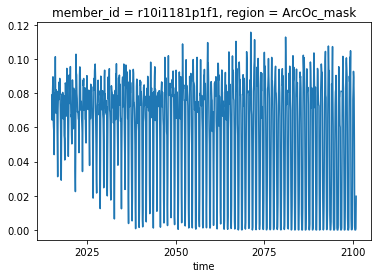

In [37]:
# check the values here
total.sel(region='ArcOc_mask').isel(member_id=0).plot()

### Actually load the data now

Before, all the calculations were "lazy" version

In [38]:
%%time
## slow step
total.load()

CPU times: user 17.4 s, sys: 610 ms, total: 18 s
Wall time: 46.1 s


<xarray.DataArray (member_id: 50, time: 1032, region: 11)>
array([[[5.62817670e-03, 4.02246744e-02, 4.54510099e-02, ...,
         4.16047034e-02, 2.44500915e-03, 1.50742250e-02],
        [5.18325732e-03, 4.29638646e-02, 3.63702429e-02, ...,
         3.32518971e-02, 1.19672943e-03, 2.86146209e-02],
        [5.78769207e-03, 4.98255955e-02, 4.76462528e-02, ...,
         3.07400841e-02, 2.03659361e-03, 1.68452812e-02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.13171206e-05, 1.16230485e-04, 7.44934949e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.04832658e-03, 4.81142750e-03, 1.09636775e-02, ...,
         0.00000000e+00, 7.51072402e-03, 0.00000000e+00]],

       [[5.51414272e-03, 4.26964684e-02, 4.00193910e-02, ...,
         2.39173447e-02, 1.28093739e-03, 3.11688326e-02],
        [6.66996148e-03, 5.20548892e-02, 4.13343533e-02, ...,
         2.85022075e-02, 1.08994003e-03, 5.29152976e-02],
        [5.54842570e-03, 4.53985357e-02, 6.18586458e-02, ...,
         1.49381527e-02, 5.89436408e-04, 5.67559155e-02],
...
        [1.46545162e-07, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.87553440e-04, 7.35520994e-04, 3.13181444e-05, ...,
         0.00000000e+00, 7.86058000e-04, 0.00000000e+00],
        [2.48441655e-03, 6.47561394e-03, 4.56308177e-03, ...,
         0.00000000e+00, 1.54165485e-02, 3.89974393e-04]],

       [[5.94275079e-03, 3.89146845e-02, 4.86440262e-02, ...,
         2.81883550e-02, 2.23377676e-03, 2.52211962e-02],
        [6.48100978e-03, 4.11710029e-02, 6.33781237e-02, ...,
         2.33721412e-02, 1.85953711e-03, 4.80546247e-02],
        [6.22378986e-03, 4.07473839e-02, 5.72007321e-02, ...,
         2.44716030e-02, 1.11165358e-03, 4.69458895e-02],
        ...,
        [8.47466929e-06, 8.49752257e-05, 0.00000000e+00, ...,
         0.00000000e+00, 2.64646037e-04, 0.00000000e+00],
        [1.08934395e-04, 8.52975205e-04, 0.00000000e+00, ...,
         0.00000000e+00, 4.56237056e-03, 0.00000000e+00],
        [1.74467337e-03, 1.19890255e-02, 1.62176466e-03, ...,
         1.37167349e-03, 1.69649268e-02, 0.00000000e+00]]])
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
  * region     (region) <U12 'nh_mask' 'Lab_mask' ... 'Okhotsk_mask'

In [39]:
total.coords

Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
  * region     (region) <U12 'nh_mask' 'Lab_mask' ... 'Okhotsk_mask'

In [40]:
total

<xarray.DataArray (member_id: 50, time: 1032, region: 11)>
array([[[5.62817670e-03, 4.02246744e-02, 4.54510099e-02, ...,
         4.16047034e-02, 2.44500915e-03, 1.50742250e-02],
        [5.18325732e-03, 4.29638646e-02, 3.63702429e-02, ...,
         3.32518971e-02, 1.19672943e-03, 2.86146209e-02],
        [5.78769207e-03, 4.98255955e-02, 4.76462528e-02, ...,
         3.07400841e-02, 2.03659361e-03, 1.68452812e-02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.13171206e-05, 1.16230485e-04, 7.44934949e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.04832658e-03, 4.81142750e-03, 1.09636775e-02, ...,
         0.00000000e+00, 7.51072402e-03, 0.00000000e+00]],

       [[5.51414272e-03, 4.26964684e-02, 4.00193910e-02, ...,
         2.39173447e-02, 1.28093739e-03, 3.11688326e-02],
        [6.66996148e-03, 5.20548892e-02, 4.13343533e-02, ...,
         2.85022075e-02, 1.08994003e-03, 5.29152976e-02],
        [5.54842570e-03, 4.53985357e-02, 6.18586458e-02, ...,
         1.49381527e-02, 5.89436408e-04, 5.67559155e-02],
...
        [1.46545162e-07, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.87553440e-04, 7.35520994e-04, 3.13181444e-05, ...,
         0.00000000e+00, 7.86058000e-04, 0.00000000e+00],
        [2.48441655e-03, 6.47561394e-03, 4.56308177e-03, ...,
         0.00000000e+00, 1.54165485e-02, 3.89974393e-04]],

       [[5.94275079e-03, 3.89146845e-02, 4.86440262e-02, ...,
         2.81883550e-02, 2.23377676e-03, 2.52211962e-02],
        [6.48100978e-03, 4.11710029e-02, 6.33781237e-02, ...,
         2.33721412e-02, 1.85953711e-03, 4.80546247e-02],
        [6.22378986e-03, 4.07473839e-02, 5.72007321e-02, ...,
         2.44716030e-02, 1.11165358e-03, 4.69458895e-02],
        ...,
        [8.47466929e-06, 8.49752257e-05, 0.00000000e+00, ...,
         0.00000000e+00, 2.64646037e-04, 0.00000000e+00],
        [1.08934395e-04, 8.52975205e-04, 0.00000000e+00, ...,
         0.00000000e+00, 4.56237056e-03, 0.00000000e+00],
        [1.74467337e-03, 1.19890255e-02, 1.62176466e-03, ...,
         1.37167349e-03, 1.69649268e-02, 0.00000000e+00]]])
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
  * region     (region) <U12 'nh_mask' 'Lab_mask' ... 'Okhotsk_mask'

### Plot just to check

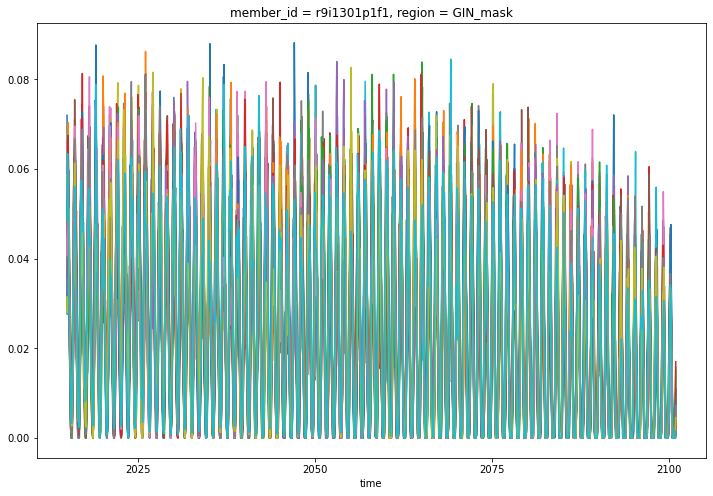

In [41]:
import nc_time_axis
# Setup the figure
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

# Loop through and plot each member_id all months in 251 years
for member_id in total.member_id.values:
    total.sel(region='GIN_mask',member_id=member_id).plot(ax=ax, label=member_id)

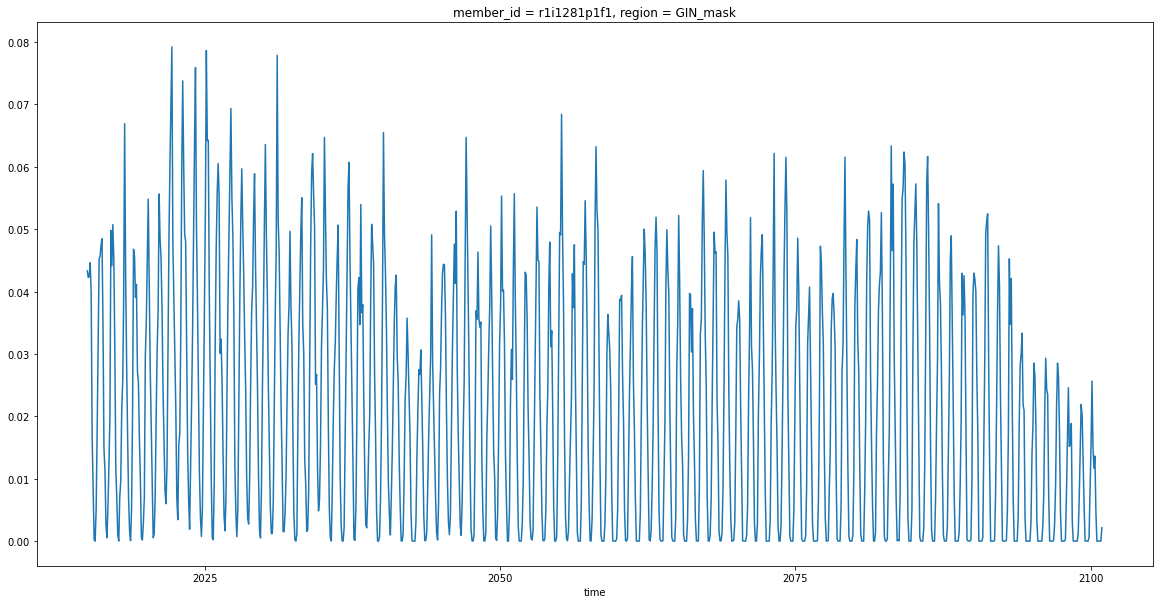

In [42]:
# Setup the figure
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

# Plot just one to check
total.sel(region='GIN_mask',member_id='r1i1281p1f1').plot(ax=ax, label='r1i1281p1f1')

### Save the timeseries

In [43]:
fout = 'CESM2-LE_all_transient_regional_avg_'+var_in_1

In [44]:
total.data.shape

(50, 1032, 11)

In [45]:
ds_to_save = xr.Dataset({'regional_totals': (['member_id','time','region'], total.data)},
                        coords={'time':(['time'],total.time.values),
                                'member_id':(['member_id'],total.member_id.values),
                                'region':(['region'],total.region.values)},
                        attrs={'Author': 'Alice DuVivier', 'units':units, 'longname':longname})

In [46]:
# double check dataset we plan to save
ds_to_save

<xarray.Dataset>
Dimensions:          (member_id: 50, time: 1032, region: 11)
Coordinates:
  * time             (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id        (member_id) <U12 'r10i1181p1f1' ... 'r9i1301p1f1'
  * region           (region) <U12 'nh_mask' 'Lab_mask' ... 'Okhotsk_mask'
Data variables:
    regional_totals  (member_id, time, region) float64 0.005628 0.04022 ... 0.0
Attributes:
    Author:    Alice DuVivier
    units:     m/s
    longname:  ice speed

In [47]:
ds_to_save.to_netcdf(fout+'.nc')  # how to save file